# Cogs9 Project: For the SDPD in 2019, is there a significant difference in the likelihood of someone being stopped according to their race? 


Group Name: CV GANG  
By Andrew Cheng  

## Analysis
**For our analysis method, we'll be using python pandas**
- link to repository-https://github.com/AndrewCheng2002/Cogs-9-Project

In [28]:
#Modules
import numpy as np
import pandas as pd
import geopandas as gpd
import math
import matplotlib.pyplot as plt
import datetime

%matplotlib inline
plt.style.use('fivethirtyeight')

**Data Collection: How do we get data to preform analysis on?**

When answering a data science question, our first task is to gather the data itself. However, not just any data will suffice, and in order to get an accurate, unbiased and ethical model, we need to ensure that our data is sufficient and representative of the population (San Diego in 2019). We need to find a source that is reliable to ensure fairness and correct represenation as well as large enough to not be affected by outliers. After some deliberation, we settled on using RIPA (i.e. an act passed by the government that requires police departments to publish their data regarding stops, arrests, etc.) to get data on [race](https://data.sandiego.gov/datasets/police-ripa-race/) and [stop](https://data.sandiego.gov/datasets/police-ripa-stops/) information. We simply downloaded the data off of the RIPA website, which was conviently in csv format. In addition to race and stop data, we also need data on specific race demographics. In this case, we decided to use the US [census](https://www.census.gov/quickfacts/fact/table/sandiegocountycalifornia/PST045219), which has information about the race distribution of San Diego County in 2019. Even though we are analyzing the SDPD in 2019, which is not a census year (every decade), we felt that the predictive algorithms used by the US government were trustworthy and sufficient enough to get an accurate representation of the population demographics. Because there was no quick download function, and we were only analyzing seven races, we decided it was easier to just webscrape the information and put it in a table.

In [2]:
#We made pandas read the RIPA csv files we downloaded
data_race_raw = pd.read_csv('ripa_race_datasd.csv')
data_stops_raw = pd.read_csv('ripa_stops_datasd.csv', low_memory = False)

#For the census we webscrapped the information and manually inserted in a table
data_census_race = pd.DataFrame({'percentage of population': [45,5.5,34.1,.9,12.6,1.3,.6]},
index = ['White','Black/African American','Hispanic/Latino/a','Middle Eastern or South Asian','Asian','Native American','Pacific Islander'])

In [3]:
data_race_raw.head(3)

,stop_id,pid,race
0,2443,1,White
1,2444,1,White
2,2447,1,Hispanic/Latino/a


In [4]:
data_stops_raw.head(3)

,stop_id,ori,agency,exp_years,date_stop,time_stop,stopduration,stop_in_response_to_cfs,officer_assignment_key,assignment,...,beat_name,pid,isstudent,perceived_limited_english,perceived_age,perceived_gender,gender_nonconforming,gend,gend_nc,perceived_lgbt
0,2443,CA0371100,SD,10,2018-07-01,00:01:37,30,0,1,"Patrol, traffic enforcement, field operations",...,Pacific Beach 122,1,0,0,25,Male,0,1,NaN,No
1,2444,CA0371100,SD,18,2018-07-01,00:03:34,10,0,1,"Patrol, traffic enforcement, field operations",...,Mission Beach 121,1,0,0,25,Male,0,1,NaN,No
2,2447,CA0371100,SD,1,2018-07-01,00:05:43,15,1,10,Other,...,El Cerrito 822,1,0,0,30,Male,0,1,NaN,No


In [5]:
data_census_race

,percentage of population
White,45.0
Black/African American,5.5
Hispanic/Latino/a,34.1
Middle Eastern or South Asian,0.9
Asian,12.6
Native American,1.3
Pacific Islander,0.6


**Data Wrangling: How do we make our data usable?**

As of now, our raw data contains a lot of information that we do not need to answer our data science question: For the SDPD in 2019, is there a significant difference in the likelihood of someone being stopped according to his/her race? The columns that we need consist of the **races** of the people stopped and the **date** in order to restrict our time interval to 2019. We have to combine it into one table, we need to first drop all the columns in the stops data that we are not using and merge that table to the race table at the **stop_id**.

Then we have to remove duplicates that arise from the merge. The reason why the merge creates duplicates is because multiple people can be stopped at one stop_id represented by the **pid** (person id), which means that there will be an addition copy of the stop_id from the dates table because the column has unique stops and does not account for pid. In addition to removing duplicates, we have to set the final table to only contain stop_ids with a date in 2019. To do this, we need to convert the dates in the date column to something we can read, such as a **datetime**. After converting the date column of strings to a datetime, we can restrict the table to only include stops from the year 2019.

In [6]:
#Make a table for race
data_race = data_race_raw.set_index('stop_id')
data_race.head()

,pid,race
stop_id,,
2443,1,White
2444,1,White
2447,1,Hispanic/Latino/a
2447,2,Hispanic/Latino/a
2448,1,White


In [7]:
#Make a table for date
data_date = pd.DataFrame().assign(date = data_stops_raw.get('date_stop'), stop_id = data_stops_raw.get('stop_id')).set_index('stop_id')
data_date.head() 

,date
stop_id,
2443,2018-07-01
2444,2018-07-01
2447,2018-07-01
2447,2018-07-01
2448,2018-07-01


In [8]:
#Merge race data set with the dates from the stop data set with the stop_id
data_merged = data_race.merge(data_date,left_index = True, right_index = True)
data_merged.head()

,pid,race,date
stop_id,,,
2443,1,White,2018-07-01
2444,1,White,2018-07-01
2447,1,Hispanic/Latino/a,2018-07-01
2447,1,Hispanic/Latino/a,2018-07-01
2447,2,Hispanic/Latino/a,2018-07-01


In [9]:
#Remove Duplicates 
data_final = data_merged.drop_duplicates()

#Get the year from the date string
def to_year(date):
    dt = datetime.datetime.strptime(date,'%Y-%m-%d')
    return dt.year

#Include data within subjected time interval
data_final = data_final[data_final.get('date').apply(to_year) == 2019]
data_final.head(9)

,pid,race,date
stop_id,,,
84362,1,Hispanic/Latino/a,2019-01-01
84364,1,White,2019-01-01
84369,1,Black/African American,2019-01-01
84372,2,Hispanic/Latino/a,2019-01-01
84376,1,Middle Eastern or South Asian,2019-01-01
84377,1,Asian,2019-01-01
84406,2,White,2019-01-01
84451,2,Black/African American,2019-01-01
84487,1,Pacific Islander,2019-01-01


**Exploratory/Descriptive Analysis: What does our data say?**

Now that we have our data neatly sorted and ready to use, we can use the data to answer our question. In order to do that, we start off by producing some basic descriptive analysis to get a general idea of the trends in our data. For the descriptive analysis, we decided to compare the percentages of each race stopped versus the percentages of each race's demographic to see if there was any significant difference between the two. We created a new table showing the percentage of each race stopped and then merged the demographic table to that table. We then generated basic statistics that compared the two distributions such as the absolute mean difference, the standard deviation of the absolute differences, and the range of the absolute differences. 

In [10]:
#Generate Race Percentages Table from the data wrangled data_final
race_percentage = data_final.groupby('race').count()/data_final.shape[0]*100
race_percentage = race_percentage.drop(columns = ['date']).rename(columns={'pid':'percentage stopped'})
race_percentage

,percentage stopped
race,
Asian,10.431055
Black/African American,20.159562
Hispanic/Latino/a,22.552989
Middle Eastern or South Asian,8.001905
Native American,3.346035
Pacific Islander,6.215766
White,29.292689


In [11]:
race_percentage

,percentage stopped
race,
Asian,10.431055
Black/African American,20.159562
Hispanic/Latino/a,22.552989
Middle Eastern or South Asian,8.001905
Native American,3.346035
Pacific Islander,6.215766
White,29.292689


Now we see that there's a difference between the two distributions in the following table below.

In [12]:
#Now merge the census data and sort by lowest population to highest
race_census_percentage = race_percentage.merge(data_census_race,left_index = True,right_index = True)
race_census_percentage = race_census_percentage.sort_values('percentage of population', ascending = True)
race_census_percentage

,percentage stopped,percentage of population
Pacific Islander,6.215766,0.6
Middle Eastern or South Asian,8.001905,0.9
Native American,3.346035,1.3
Black/African American,20.159562,5.5
Asian,10.431055,12.6
Hispanic/Latino/a,22.552989,34.1
White,29.292689,45.0


Basic Statistics generated below:

In [13]:
difference = race_census_percentage.get('percentage stopped')-race_census_percentage.get('percentage of population')
mean_abs_diff = abs(difference).mean()
std_abs_diff = np.std(abs(difference))
range_abs_diff = abs(difference).max()-abs(difference).min()
print('mean abs diff: '+ str(mean_abs_diff) +'%, std abs diff: ' + str(std_abs_diff) + '%, range abs diff: ' + str(range_abs_diff)+'%')

mean abs diff: 8.406647841322764%, std abs diff: 5.22518917771041%, range abs diff: 13.661276494403433%


Our descriptive analysis shows that there is a decent chance that race is correlated with the likelihood of being stopped by the police in San Diego with the mean difference from the demographic being 8.41%. Assuming that these results are realiable (proven later in our statistical analysis), we can then use this to justify or disprove our hypothesis that blacks and hispanics are stopped more frequently by the police compared to other races. 

**Data Visualization: What does the data show us?**

Once we completed some basic analysis, the next step is to visualize the data and see how each race compares to its demographic. With Pandas, it is really easy and simple to create a visualization, since we already have a completed table from the exploratory analysis and data wrangling we did. We decided to make a grouped bar graph to compare the distribution of two categorical variables. We chose blue and orange as the colors and made the graph a bit wider to make it easier on the eyes. As you can see, minorities are stopped much more often than the rest of the races. Black/African Americans are especially targeted and Asians and Whites much less, which supports our hypothesis. However, Hispanics/Latinos are surprisingly stopped less relative to their population according to the visualization, which goes against our hypothesis. 

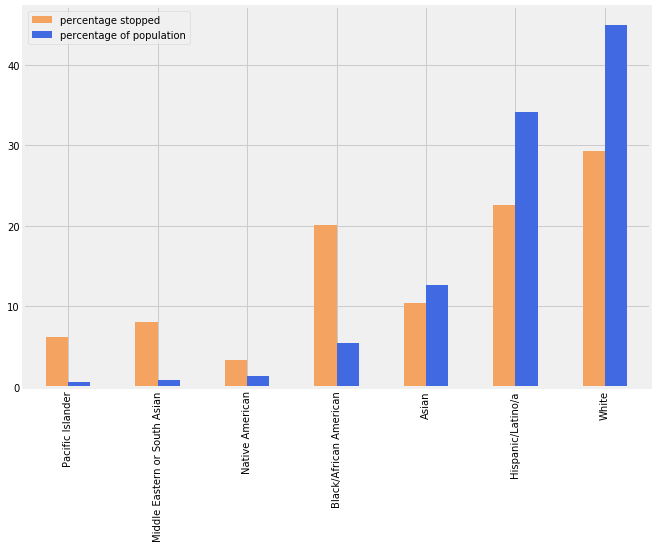

In [14]:
race_census_percentage.plot(kind = 'bar', figsize = [10,7],color = ['sandybrown','royalblue'])

**Statistical Analysis: How do we know that our results are trustworthy?**

After performing exploratory analysis to generate basic statistics and produce a visualization, we need to make sure that these results are valid and significant. In order to achieve this, we will perform a hypothesis test and calculate a confidence interval and p-value for our statistic.

- Null: There is no significant difference between the percentage of races stopped relative to their demographic.
- Alternate: There is a significant difference between the percentage of race stopped relative to their demographic.

In [15]:
#Test Statistic will be the Mean Difference
test_stat = mean_abs_diff
test_stat

8.406647841322764

In [16]:
#We'll generate about 5000 sample test stats using the census data to create a 95% confidence interval

num_repetitions = 5000
population = data_final.shape[0]

simulated_test_stats = np.array([])

for i in range(num_repetitions):
    model_proportions = race_census_percentage.get('percentage of population')/100
    sample = np.random.multinomial(population, model_proportions)/population
    sim_test_stat = abs(model_proportions-sample).mean()*100
    simulated_test_stats = np.append(simulated_test_stats, sim_test_stat)

simulated_test_stats

array([0.26393359, 0.28531283, 0.28094444, ..., 0.28043412, 0.27183343,
       0.27020719])

Confidence Interval: [0.08236978192086544, 0.4246982274691252]


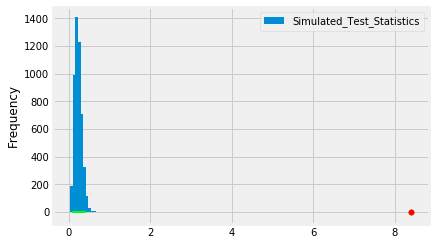

In [17]:
#Lets look at the distribution and generate the 95% confidence interval
t = pd.DataFrame().assign(Simulated_Test_Statistics = simulated_test_stats)
t.plot(kind='hist')

confidence_interval = [np.percentile(simulated_test_stats,2.5),np.percentile(simulated_test_stats,97.5)]
plt.scatter(test_stat, 0, color='red', s=30);
plt.plot(confidence_interval,[0,0], color = 'lime', linewidth = 2)
print('Confidence Interval: [' + str(confidence_interval[0]) +', ' + str(confidence_interval[1]) + ']')

In [18]:
#Now lets generate a p value
p_value = np.count_nonzero(simulated_test_stats >= test_stat)/simulated_test_stats.shape[0]
print('p value: ' + str(p_value))

p value: 0.0


We reject the null, therefore the difference in the percentages of races being stopped is statistically significant. With this test, we are confident in using the results to justify our hypothesis.

**Geospatial Analysis: Is there any bias in our data due to the location of the stops?**

In this analysis, we compare the total distribution of the San Diego police stops to the total demographic of San Diego to see if there is any difference between the two. However, the police may not uniformly patrol each district of San Diego. For example, the police might be more active in urban areas, where minorities may make up more of the population as opposed to suburbs, where most of the populations are Whites, Hispanics, and Asians. We will perform a geospatial analysis to see if the frequency a police stops at a location has an effect on the mean difference of races to demographic stopped. This will tell us if there is any bias in our data and how severe it is.

The process will involve using geopandas to read a geodataframe in the form of a shape file. The shape file data we will be using is from [ripa](https://data.sandiego.gov/datasets/police-beats/), which contains a beat map (i.e. a territory an officer patrols) of the San Diego County. To start off with our geospatial analysis, we need to do a bit of additional data wrangling by adding the beat data to our data final table. After adding all the neccessary columns (the frequency of stops at each beat and the mean absolute difference of race to demographic of each beat), we will use the beat map to create visualizations to look for possible correlations, hence bias in our data. More specifically, we made a choropleth that represents how much each beat was affected by the police according to the frequency of stops and a choropleth that compared the mean absolute difference of each beat. We then stacked the graphs to see if there was any correlation in our data that could suggest biases or confounding variables, such as the location or the wealth of an individual.

In [19]:
#Data Wrangling

#We'll add the location to our final data set
data_loc = pd.DataFrame().assign(stop_id = data_stops_raw.get('stop_id'),beat = data_stops_raw.get('beat'))
data_loc = data_loc.set_index('stop_id')
data_geo = data_final.merge(data_loc,left_index = True, right_index = True)
data_geo = data_geo.drop_duplicates()
data_geo.head()

,pid,race,date,beat
stop_id,,,,
84362,1,Hispanic/Latino/a,2019-01-01,839
84364,1,White,2019-01-01,124
84369,1,Black/African American,2019-01-01,614
84372,2,Hispanic/Latino/a,2019-01-01,122
84376,1,Middle Eastern or South Asian,2019-01-01,122


In [20]:
#This is the frequency of stops for each beat
geo_final = data_geo.groupby('beat').count()
geo_final = geo_final.assign(frequency = geo_final.get('pid')).drop(columns=['pid','date','race'])
geo_final.head()

,frequency
beat,
111,67
112,26
113,23
114,50
115,53


In [21]:
#This is the returns absolute mean difference of each beat 
def get_mean_diff(races):
    race_percentages = races/races.sum()*100
    return abs(race_percentages.get('frequency')- data_census_race.get('percentage of population')).mean()

In [22]:
#Generating the final table with mean abs difference and frequency
geo_diff = data_geo.groupby(['beat','race']).count().unstack(fill_value=0).stack()
geo_diff = geo_diff.assign(frequency = geo_diff.get('pid')).drop(columns=['pid','date'])

mean_diff = np.array([])
for i in geo_final.index:
    mean_diff = np.append(mean_diff, get_mean_diff(geo_diff.loc[i]))

geo_final = geo_final.assign(mean_diff = mean_diff)
geo_final.head(7)

,frequency,mean_diff
beat,,
111,67,10.233262
112,26,9.791209
113,23,7.959006
114,50,11.171429
115,53,11.772507
116,48,11.319048
121,638,4.489028


In [23]:
beat_map_raw = gpd.read_file('pd_beats_datasd/pd_beats_datasd.shp')
beat_map_raw.head(8)

,objectid,beat,div,serv,name,geometry
0,3,935,9,930,NORTH CITY,"MULTIPOLYGON (((6268975.465 1931147.469, 62689..."
1,7,0,0,0,SAN DIEGO,"MULTIPOLYGON (((6261648.576 1836846.672, 62616..."
2,8,511,5,510,None,"MULTIPOLYGON (((6261640.429 1836823.561, 62616..."
3,9,722,7,720,NESTOR,"POLYGON ((6302781.000 1793246.001, 6302905.000..."
4,10,314,3,310,BIRDLAND,"POLYGON ((6284667.652 1874418.895, 6284694.392..."
5,11,839,8,830,CHEROKEE POINT,"POLYGON ((6294214.000 1853698.000, 6294393.000..."
6,12,612,6,610,LOMA PORTAL,"POLYGON ((6263446.993 1854500.089, 6263451.987..."
7,13,625,6,620,OLD TOWN,"POLYGON ((6271080.000 1857793.000, 6271077.855..."


In [24]:
beat_visual= beat_map_raw.merge(geo_final, left_on = 'beat',right_index = True, how = 'left')
beat_visual.head(9)

,objectid,beat,div,serv,name,geometry,frequency,mean_diff
0,3,935,9,930,NORTH CITY,"MULTIPOLYGON (((6268975.465 1931147.469, 62689...",19.0,7.278195
1,7,0,0,0,SAN DIEGO,"MULTIPOLYGON (((6261648.576 1836846.672, 62616...",NaN,NaN
2,8,511,5,510,None,"MULTIPOLYGON (((6261640.429 1836823.561, 62616...",117.0,11.084737
3,9,722,7,720,NESTOR,"POLYGON ((6302781.000 1793246.001, 6302905.000...",27.0,13.114286
4,10,314,3,310,BIRDLAND,"POLYGON ((6284667.652 1874418.895, 6284694.392...",21.0,20.136054
5,11,839,8,830,CHEROKEE POINT,"POLYGON ((6294214.000 1853698.000, 6294393.000...",15.0,10.914286
6,12,612,6,610,LOMA PORTAL,"POLYGON ((6263446.993 1854500.089, 6263451.987...",18.0,9.168254
7,13,625,6,620,OLD TOWN,"POLYGON ((6271080.000 1857793.000, 6271077.855...",62.0,13.296774
8,14,714,7,710,BORDER,"POLYGON ((6321769.005 1778788.482, 6321947.141...",25.0,14.542857


**Choropleth -police activity:** As you can see below, the downtown areas have relativity more police activity compared to the subards as the shade becomes lighter towards the northern beats.

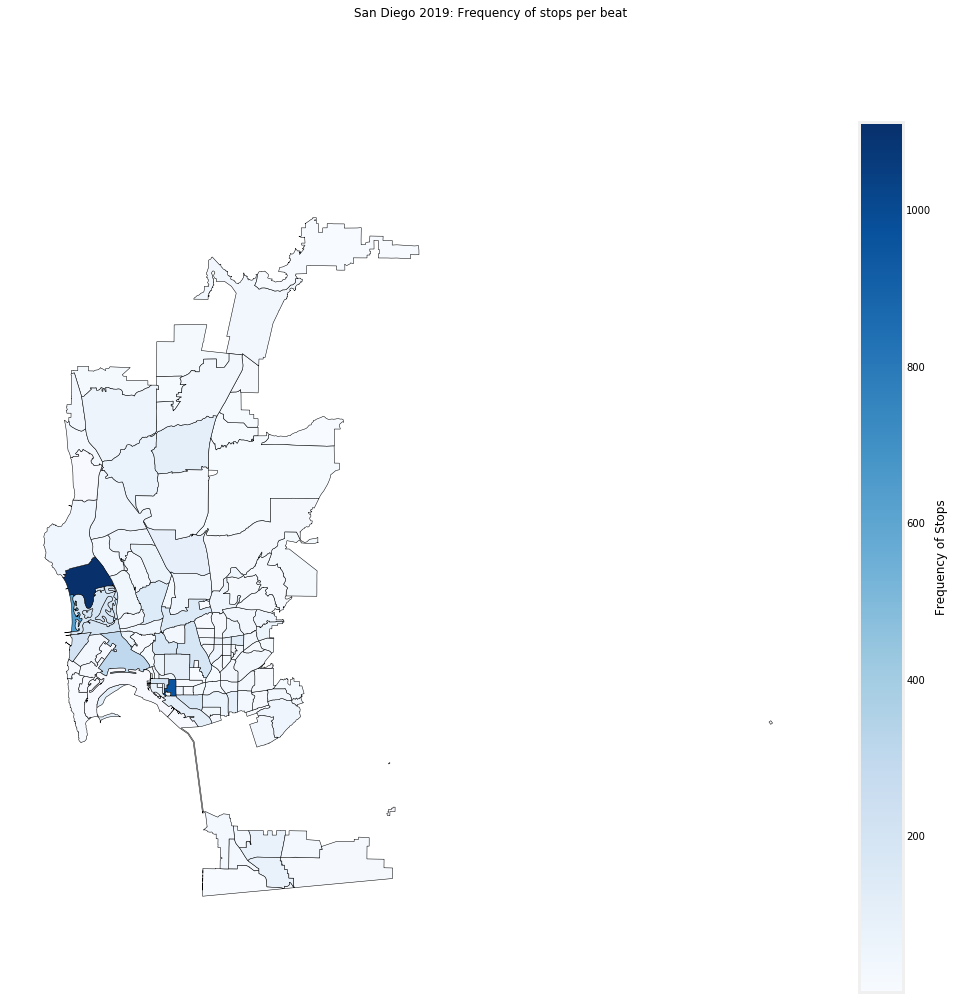

In [25]:
#Beats with no stops are represented to have no mean difference (white), as the distribution is technically uniform
beat_visual.plot(column = 'frequency',figsize = [16,16], legend=True, cmap='Blues', edgecolor="black",
                 legend_kwds={'label': "Frequency of Stops"}, missing_kwds={'color': 'ghostwhite'})

plt.axis('off')

plt.suptitle('San Diego 2019: Frequency of stops per beat')
plt.show()

**Choropleth -Mean Diff:** As you can see below, beats from the downtown area of San Diego County have higher mean differences compared to the suburbs located more north.

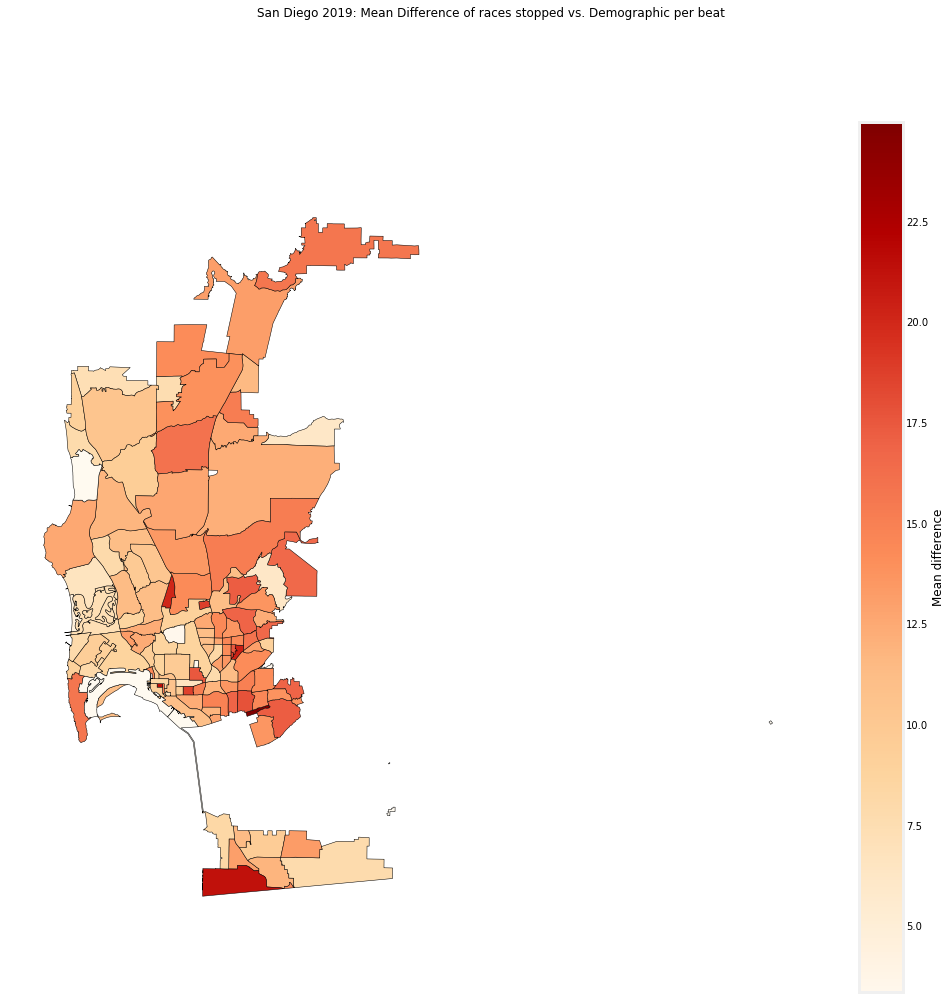

In [26]:
#Beats with no stops are represented to have no mean difference (white), as the distribution is technically uniform
beat_visual.plot(column = 'mean_diff',figsize = [16,16], legend=True, cmap='OrRd', edgecolor="black",
                 legend_kwds={'label': "Mean difference"}, missing_kwds={'color': 'floralwhite'})

plt.axis('off')

plt.suptitle('San Diego 2019: Mean Difference of races stopped vs. Demographic per beat')
plt.show()

**Stacked Choropleth:** Now lets see how similar the two graphs compare when we overlay them. Although they do not completely align, the downtown area, where more minorities reside, are more purple, which shows that higher activity of police is somewhat correlated with the mean difference. However, beats that are towards the west are more blue and beats towards the north are more red, which may indicate that there is not enough data or that there is confounding variable.

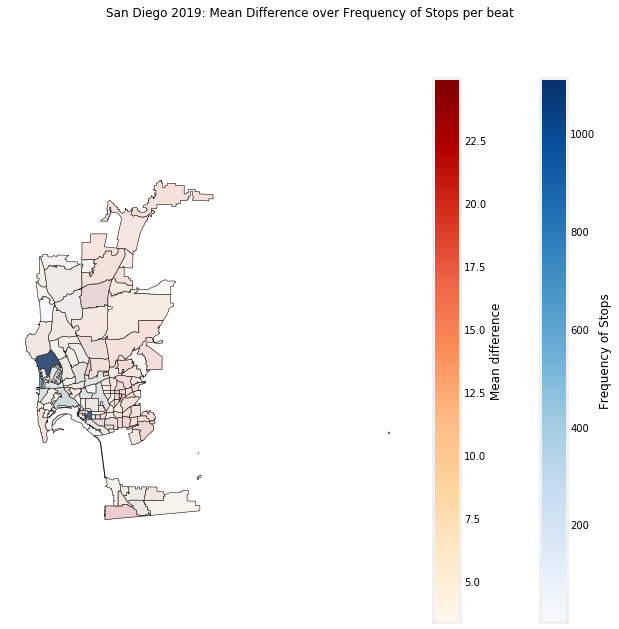

In [27]:
ax = beat_visual.plot(column = 'frequency',figsize = [10,10], legend=True, cmap='Blues', edgecolor="black",legend_kwds={'label': "Frequency of Stops"}, missing_kwds={'color': 'ghostwhite'})
beat_visual.plot(column = 'mean_diff',figsize = [10,10], legend=True, cmap='OrRd', edgecolor="black",legend_kwds={'label': "Mean difference"}, missing_kwds={'color': 'floralwhite'}, ax = ax,alpha = .2)
plt.axis('off')
plt.suptitle('San Diego 2019: Mean Difference over Frequency of Stops per beat')
plt.show()

**Conclusion: Is our question answered?**

Although we performed a hypothesis test and computed a p-value of less than .05, our exploratory analysis may still contain biases and inaccuracies as shown in our geospatial analysis. However, we believe that this is not enough to completely invalidate our findings, but we should be conscious that our results may be slighty skewed from not accounting for societal bias. For example, police are more active in downtown areas, which are typically inhabited by more minorities and thus have greater mean differences. From our statistical analysis, we concluded that there is a relationship between someone's race and his/her likelihood of being stopped by the police. After reflecting, parts of our hypothesis were proven right and wrong. We said that Blacks/African Americans were more likely of being stopped, which the data firmly suggested. However, we also hypothesized that Latinos/Hispanics would also be targeted more, but according to our findings, this was not the case as it was even less likely for them to be stopped. In conclusion, the trend seems to be that minorities are stopped more often than other races in the demographic of San Diego in 2019. 